In [1]:
import os
import json

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset
from tqdm import tqdm

import transformer_lens
import random
from probe_model import LinearProbe, Trainer, TrainerConfig

/home/rsn3254/.conda/envs/jupyter-kernel-py38/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import importlib
import probe_model
importlib.reload(probe_model)
from probe_model import LinearProbe, Trainer, TrainerConfig
import spacy

## Setup

In [3]:
device_name = "cpu"
if torch.cuda.is_available():
    device_name = "cuda" # CUDA for NVIDIA GPU

device = torch.device(device_name)
print(f"Device: {device_name}")

Device: cuda


In [4]:
model_name = "gpt2-small"
model = transformer_lens.HookedTransformer.from_pretrained(model_name)

Loaded pretrained model gpt2-small into HookedTransformer


In [5]:
# Load the spaCy model
spacy_model = spacy.load("en_core_web_sm")

## Generate dataset

### Load text

In [6]:
# N_WORDS = 10000
# with open('datasets/common_words.txt', 'r') as file:
#     words = np.random.choice([l.rstrip("\n") for l in file.readlines()], N_WORDS)
#     #print(words)
# word_len_dict = {w: len(model.to_tokens(f" {w}", prepend_bos=False).squeeze(0)) for w in words}
# word_len = np.vectorize(lambda x: word_len_dict[x])
#take in a list of words, return a list where each element is the token-length of the corresponding word

In [12]:
with open('datasets/prewar.txt', 'r') as f:
    prewar = [line.rstrip("\n") for line in f.readlines()]

PREWAR_CUTOFF = 2000

word_dict = {}
word_len_prewar = np.vectorize(lambda x: word_dict[x])
for text in tqdm(prewar[:PREWAR_CUTOFF]):
    gpt_tokens = model.to_tokens(text).squeeze(0)
    gpt_tokens_str = [model.to_single_str_token(int(t)) for t in gpt_tokens]
    #print(gpt_tokens)
    doc = spacy_model(text)
    words = [t.text for t in doc if t.is_alpha]
    #print(doc)
    #word_idxs = []
    
    i = 0
    cur = 0 # current word index
    sub_idx = 0 # sub index of current word
    #print(gpt_tokens_str)
    tokens = 0 # number of tokens for this word
    
    if not len(words):
        continue
            
    while i < len(gpt_tokens_str):
        t = gpt_tokens_str[i].strip()
        # skip if token is just a newline or other whitespace
        if not len(t):
            i += 1
            tokens = 0
            continue
        
        cur_word = words[cur]
        
        # if token is part of current word, update sub_idx, continue to next token
        if cur_word.find(t, sub_idx) != -1:
            
            if cur_word in word_dict: 
                if word_dict[cur_word] < tokens:
                    word_dict[cur_word] = tokens
            else:
                word_dict[cur_word] = tokens
            sub_idx += len(t)
            i += 1
            tokens += 1
        else:
            
            if cur+1 < len(words) and t in words[cur+1]:
                cur += 1
                sub_idx = 0
                tokens = 1
            else:
                
                i += 1 
                tokens = 1
print(word_dict)

100%|██████████| 2000/2000 [00:17<00:00, 117.40it/s]

{'the': 1, 'repeal': 2, 'of': 1, 'missouri': 2, 'compromise': 1, 'and': 1, 'propriety': 2, 'its': 1, 'restoration': 1, 'constitute': 1, 'subject': 1, 'what': 1, 'i': 1, 'am': 1, 'about': 1, 'to': 1, 'say': 1, 'as': 1, 'desire': 1, 'present': 1, 'my': 1, 'own': 1, 'connected': 1, 'view': 1, 'this': 1, 'remarks': 1, 'will': 1, 'not': 1, 'be': 1, 'specifically': 1, 'an': 1, 'answer': 1, 'judge': 2, 'douglas': 2, 'yet': 1, 'proceed': 1, 'main': 1, 'points': 1, 'he': 1, 'has': 1, 'presented': 1, 'arise': 1, 'receive': 1, 'such': 1, 'respectful': 1, 'attention': 1, 'may': 1, 'able': 1, 'give': 1, 'them': 1, 'wish': 1, 'further': 1, 'that': 1, 'do': 1, 'propose': 1, 'question': 1, 'patriotism': 1, 'or': 1, 'assail': 1, 'motives': 1, 'any': 1, 'man': 1, 'class': 1, 'men': 1, 'but': 1, 'rather': 1, 'strictly': 1, 'confine': 2, 'myself': 1, 'naked': 1, 'merits': 1, 'also': 1, 'no': 1, 'less': 1, 'than': 1, 'national': 1, 'in': 1, 'all': 1, 'positions': 1, 'take': 1, 'whenever': 1, 'ground': 1, '

### generating

In [13]:
PREFIX = "the repeal of missouri .\nwhat "
BATCH_SIZE = 256
N_SAMPLE = 10

prefix_len = len(model.to_tokens(PREFIX, prepend_bos=True).squeeze(0)) - 1

def generate_batch():
    batch_words = []
    for i in range(BATCH_SIZE):
        invalid_sentence = True
        while invalid_sentence:
            sentence = random.choice(prewar[:PREWAR_CUTOFF])
            #make the sentence fit
            #print(sentence)
            doc = spacy_model(str(sentence))
            words = [t.text for t in doc if t.is_alpha]
            if(len(words) >= 10):
                sampled = words[:10]
                invalid_sentence = False
        
        #sampled = np.random.choice(words, N_SAMPLE)
        batch_words.append(sampled)
    
    tokens = model.to_tokens([PREFIX + " ".join(s) for s in batch_words], prepend_bos=True)
    mapped_len = word_len_prewar(batch_words)

    word_idxs = np.ones((BATCH_SIZE, N_SAMPLE * 3)) * -1
    for i, r in enumerate(mapped_len):
        row = np.repeat(np.arange(N_SAMPLE), r)
        word_idxs[i, :len(row)] = row

    return tokens, word_idxs

In [14]:
DATA_BATCHES = 50

torch.set_grad_enabled(False)

all_resids = []
all_word_idxs = []

for i_batch in tqdm(range(DATA_BATCHES)):
    tokens, word_idxs = generate_batch()
    _, cache = model.run_with_cache(tokens, names_filter=lambda x: x.endswith("resid_post"))
    residuals = cache.stack_activation("resid_post")

    residuals = residuals[:, :, prefix_len:, :]
    word_idxs = word_idxs[:, :residuals.size(dim=2)]

    mask = word_idxs != -1

    all_resids.append(residuals.cpu().numpy()[:, mask].reshape(12, -1, model.cfg.d_model))
    all_word_idxs.append(word_idxs[mask])


100%|██████████| 50/50 [01:54<00:00,  2.28s/it]


In [15]:
print(np.array(all_resids))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (50, 12) + inhomogeneous part.

In [16]:
x_all_layers = np.concatenate(all_resids, axis=1)
y = np.concatenate(all_word_idxs)

print(x_all_layers.shape)
print(y.shape)

(12, 138013, 768)
(138013,)


## Training Probes

In [17]:
class ProbingDataset(Dataset):
    def __init__(self, act, y):
        assert len(act) == len(y)
        print(f"dataset: {len(act)} pairs loaded...")
        self.act = act
        self.y = y
        print("y:", np.unique(y, return_counts=True))
        
    def __len__(self, ):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.tensor(self.act[idx]), torch.tensor(self.y[idx]).long()

In [18]:
LAYER = 3
x = x_all_layers[LAYER, :, :]

probing_dataset = ProbingDataset(x, y)
train_size = int(0.8 * len(probing_dataset))
test_size = len(probing_dataset) - train_size
probe_train_dataset, probe_test_dataset = torch.utils.data.random_split(probing_dataset, [train_size, test_size])
print(f"split into [test/train], [{test_size}/{train_size}]")

dataset: 138013 pairs loaded...
y: (array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([13837, 13916, 13805, 13673, 13929, 13762, 13610, 13803, 13773,
       13905]))
split into [test/train], [27603/110410]


In [19]:
probe = LinearProbe(device, 768, 10)

folder = f"ckpts/{model_name}/randwords_159k/layer{LAYER}"
config = TrainerConfig(num_epochs=40, ckpt_path=folder)
trainer = Trainer(device, probe, probe_train_dataset, probe_test_dataset, config)

In [20]:
trainer.train()

Epoch 40; Train Loss: 0.55828; Train Acc: 80.193%; Test Acc: 79.191%: 100%|██████████| 40/40 [01:45<00:00,  2.64s/it]


In [21]:
print(trainer.generate_report())

              precision    recall  f1-score   support

           0     0.9982    0.9956    0.9969      2749
           1     0.9771    0.9673    0.9722      2692
           2     0.9057    0.9314    0.9184      2724
           3     0.8077    0.8098    0.8088      2713
           4     0.7195    0.7571    0.7378      2771
           5     0.7769    0.5830    0.6661      2832
           6     0.6059    0.7547    0.6722      2793
           7     0.6763    0.6517    0.6637      2776
           8     0.7174    0.6338    0.6730      2783
           9     0.7792    0.8498    0.8130      2770

    accuracy                         0.7919     27603
   macro avg     0.7964    0.7934    0.7922     27603
weighted avg     0.7953    0.7919    0.7908     27603



### plotting loss curves

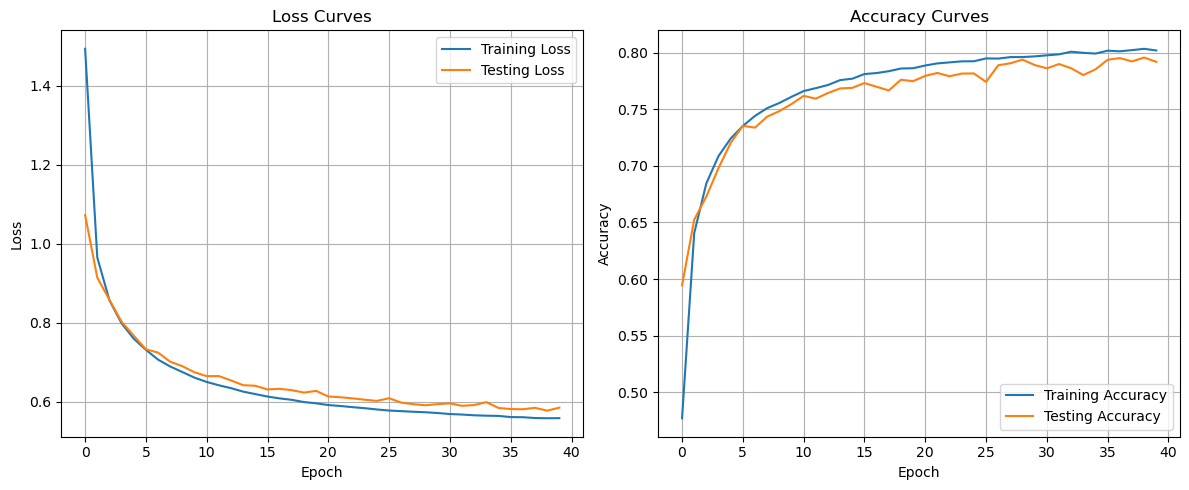

In [22]:
metrics_path = os.path.join(folder, 'metrics.json')

# Load the metrics from the JSON file
with open(metrics_path, 'r') as f:
    metrics = json.load(f)['metrics']

# Extract the loss and accuracy data
train_loss = metrics['train_loss']
test_loss = metrics['test_loss']
train_acc = metrics['train_acc']
test_acc = metrics['test_acc']

# Plot the loss curves
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(test_acc, label='Testing Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()